<hr>

# 6 Copernicus Sentinel-3 SLSTR NRT - Aerosol Optical Depth (AOD) - Level 2

The [Copernicus Sentinel-3 SLSTR Near-Real-Time (NRT) Aerosol Optical Depth (AOD)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0306?query=SLSTR%20Level%202%20Aerosol%20Optical%20Depth%20in%20NRT%20-%20Sentinel-3&s=advanced) product quantifies the abundance of all aerosol particles suspended in the air and monitors their global distribution and long-range transport, at the scale of 9.5 x 9.5 km<sup>2</sup>. Aerosol Optical Depth is often used as a proxy for the amount of aerosols in the air.

The NRT S3 AOD product is only applicable during daytime. The current version of the product is considered as `'preliminary operational'` over ocean surfaces, and `'demonstrational'` over land surfaces.

All these observations are made available in less than three hours from the SLSTR observation sensing time.

The following workflow is based on an example of `Sentinel-3 Near Real Time SLSTR AOD` data on 25 August 2024 in order analyse the amount of aerosols in the air.
 

#### This module has the following outline:
* [1 - Load Sentinel-3 SLSTR NRT AOD data](#load_cal)
* [2 - Extract AOD variables](#extract_cal)
* [3 - Visualize AOD Ocean and AOD land information](#visualize_cal)

<hr>

#### Load required libraries

In [1]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0 satpy==0.51.0 pyhdf h5py python-geotiepoints

In [2]:
import xarray as xr
import glob
import zipfile

import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
if os.path.exists("functions.ipynb"):
    %run functions.ipynb
elif os.path.exists("../functions.ipynb"):
    %run ../functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
    %run functions.ipynb

In [4]:
if os.path.exists("bucket_functions.ipynb"):
    %run bucket_functions.ipynb
elif os.path.exists("../bucket_functions.ipynb"):
    %run ../bucket_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/bucket_functions.ipynb
    %run bucket_functions.ipynb

In [5]:
base_url = 'https://s3.waw3-2.cloudferro.com/swift/v1/wmo/'
all_paths_list = list_data_on_bucket(base_url)

all_directories_list = [os.path.dirname(path) for path in all_paths_list if path.count('/') <= 4]
# Take unique directories
all_directories_list = list(np.unique(all_directories_list))
all_directories_list

Status ok



[np.str_('eodata'),
 np.str_('eodata/fci'),
 np.str_('eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000'),
 np.str_('eodata/gome2'),
 np.str_('eodata/gome2/aai'),
 np.str_('eodata/gome2/hcho'),
 np.str_('eodata/gome2/hcho/daily'),
 np.str_('eodata/gome2/no2'),
 np.str_('eodata/gome2/no2/daily'),
 np.str_('eodata/iasi'),
 np.str_('eodata/iasi/co'),
 np.str_('eodata/iasi/nh3'),
 np.str_('eodata/meteosat'),
 np.str_('eodata/meteosat/2020'),
 np.str_('eodata/meteosat/2024'),
 np.str_('eodata/modis'),
 np.str_('eodata/modis/10km'),
 np.str_('eodata/modis/level_1b'),
 np.str_('eodata/monarch'),
 np.str_('eodata/pmap'),
 np.str_('eodata/s3'),
 np.str_('eodata/s3/aod'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240821T082340_20240821T082839_20240821T101507_0299_116_078______MAR_O_NR_003.SEN3'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240825T081954_20240825T082453_20240825T101112_0299_116_

#### Define geographical area

In [6]:
latmin = -40
latmax = 10
lonmin = 0
lonmax = 40

<hr>

## <a id='load'></a>Load Sentinel-3 SLSTR Near-Real-Time AOD data

The Near-Real-Time Sentinel-3 Aerosol Optical Depth data are disseminated in `netCDF`. `netCDF` data can be loaded with the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `xr.open_dataset()`. 

You see that the data file contains two `dimensions`:
* `columns` and
* `rows`.

It further contains an long list of `data variables`, including:
* `AOD_550`,
* `AOD_550_uncertainty`,
* `AOD_550_Ocean_NonFiltered`,
* `AOD_550_Land_Experimental_PostFiltered`,
...

A data file also contains a set of `attributes`, which give you more information about the data file and the data it contains, e.g the `start_time` and `stop_time` or the `product_name`.

In [7]:
path = base_url + 'eodata/s3/aod/S3B_SL_2_AOD____20240823T083336_20240823T083833_20240823T102404_0299_096_349______MAR_O_NR_003.SEN3/'
file = open_data_from_bucket(path+'NRT_AOD.nc')
file

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/s3/aod/S3B_SL_2_AOD____20240823T083336_20240823T083833_20240823T102404_0299_096_349______MAR_O_NR_003.SEN3/NRT_AOD.nc


<xarray.Dataset> Size: 8MB
Dimensions:                                (rows: 210, columns: 157)
Coordinates:
    longitude                              (rows, columns) float32 132kB ...
Dimensions without coordinates: rows, columns
Data variables: (12/57)
    AOD_550                                (rows, columns) float32 132kB ...
    AOD_550_Land                           (rows, columns) float32 132kB ...
    AOD_550_uncertainty                    (rows, columns) float32 132kB ...
    AOD_550_uncertainty_Land               (rows, columns) float32 132kB ...
    AOD_550_Merged_OceanLand               (rows, columns) float32 132kB ...
    AOD_670                                (rows, columns) float32 132kB ...
    ...                                     ...
    scattering_angle_oblique               (rows, columns) float32 132kB ...
    cloud_fraction_nadir                   (rows, columns) float32 132kB ...
    cloud_fraction_oblique                 (rows, columns) float32 132kB ...
    aod_quality_flags                      (rows, columns) uint16 66kB ...
    SLN_L1b_quality_flags                  (rows, columns) uint32 132kB ...
    SLO_L1b_quality_flags                  (rows, columns) uint32 132kB ...
Attributes: (12/17)
    title:                  Surface directional Reflectance, retrieved and de...
    comment:                 
    netCDF_version:         4.2 of Apr 12 2021 08:07:42 $
    product_name:           S3B_SL_2_AOD____20240823T083336_20240823T083833_2...
    institution:            MAR
    source:                 IPF-SL-2-AOD 04.02
    ...                     ...
    absolute_orbit_number:  32961
    start_time:             2024-08-23T08:33:35.510716Z
    stop_time:              2024-08-23T08:38:33.400246Z
    processing_baseline:    AOD_NRT.003.01.00
    track_offset:           105
    start_offset:           2116

### <a id='extract'></a>Extract Aerosol Optical Depth variables

The next step is to extract the variables of interest. Let us select the following two variables:
* `AOD_550`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers ocean surfaces.*)
* `AOD_550_Land`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers land surfaces.*)

Both `xarray.DataArrays` have two dimensions (`rows` and `columns`) and the following attributes, which provide additional information about the variables:
* `long_name`
* `standard_name`
* `valid_min`
* `valid_max`
* `coordinates`

In [8]:
aod_ocean = file.AOD_550
aod_land = file.AOD_550_Land

print(aod_ocean)
print(' ')
print(aod_land)

<xarray.DataArray 'AOD_550' (rows: 210, columns: 157)> Size: 132kB
[32970 values with dtype=float32]
Coordinates:
    longitude  (rows, columns) float32 132kB ...
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Aerosol optical thickness at 550 nm - Best quality (post-...
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol
    valid_min:      0.0
    valid_max:      4.001
 
<xarray.DataArray 'AOD_550_Land' (rows: 210, columns: 157)> Size: 132kB
[32970 values with dtype=float32]
Coordinates:
    longitude  (rows, columns) float32 132kB ...
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Aerosol optical thickness at 550 nm - Only over land surf...
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol
    valid_min:      0.0
    valid_max:      4.001


You can also load `latitude` and `longitude` information, which can be used later for visualizing the variables.

In [9]:
lat_nc = file.latitude
lon_nc = file.longitude

print(lat_nc)
print(' ')
print(lon_nc)

<xarray.DataArray 'latitude' (rows: 210, columns: 157)> Size: 132kB
[32970 values with dtype=float32]
Coordinates:
    longitude  (rows, columns) float32 132kB ...
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Latitude at pixel centre
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0
 
<xarray.DataArray 'longitude' (rows: 210, columns: 157)> Size: 132kB
[32970 values with dtype=float32]
Coordinates:
    longitude  (rows, columns) float32 132kB ...
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Longitude at pixel centre
    standard_name:  longitude
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0


### <a id='visualize'></a> Visualize AOD Ocean and AOD Land variables

The final step is to visualize both variables, Aerosol Optical Depth over ocean and land together in one plot. You can use matplotlib's function `pcolormesh` for it.

Let us define a function called [visualize_s3_aod](../functions.ipynb#visualize_s3_aod) which visualizes both AOD variables together onto a map. The function takes the following keyword arguments (kwargs):
* `aod_ocean`: DataArray with AOD values over ocean
* `aod_land`: DataArray with AOD values over land
* `latitude`: DataArray with latitude information
* `longitude`: DataArray with longitude information
* `title`: Title of the plot
* `unit`: Unit of AOD
* `vmin` and `vmax`: Minimum and maximum values to be displayed on the map
* `color_scale`: Color scale the data shall be represented
* `projection`: Projection of the map

Now, let us apply the function [visualize_s3_aod](../functions.ipynb#visualize_s3_aod) to visualize both variables, `AOD Ocean` and `AOD Land`.

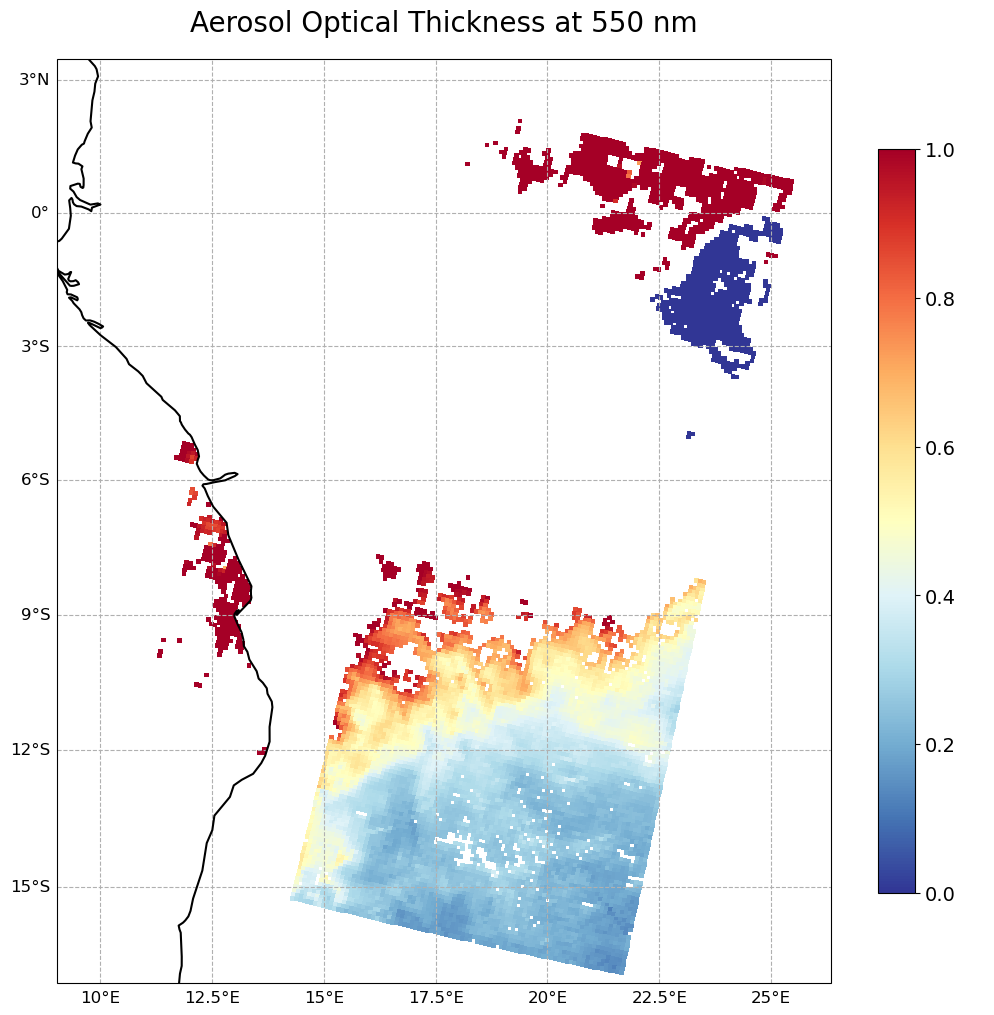

In [10]:
visualize_s3_aod(aod_ocean=aod_ocean, 
                 aod_land=aod_land, 
                 latitude=lat_nc, 
                 longitude=lon_nc, 
                 title='Aerosol Optical Thickness at 550 nm', 
                 unit=' ', 
                 vmin=0.,
                 vmax=1.0,
                 color_scale=cm.RdYlBu_r,
                 projection=ccrs.Mercator())

<br>

<br>

<hr>

### Resources
This notebook was adapted from: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/253_Sentinel-3_SLSTR_NRT_AOD_L2_load_browse.ipynb?ref_type=heads

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>